In [1]:
import pickle
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


# Load X
with open('../input/fused-data/Fused Data/X_fused.pkl', 'rb') as f:
    X = pickle.load(f)

# Load y
with open('../input/fused-data/Fused Data/y_fused.pkl', 'rb') as f:
    y = pickle.load(f)

2024-12-02 10:09:32.461221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 10:09:32.461324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 10:09:32.592349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

def Plot_history(X_test, y_pred, history):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    

    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for accuracy, loss, and confusion matrix
    
    # Plot accuracy
    axs[0].plot(history.history["accuracy"], label="Train")
    axs[0].plot(history.history["val_accuracy"], label="Test")
    axs[0].set_ylabel("Accuracy",fontsize=14)
    axs[0].set_xlabel("Number of Epochs",fontsize=14)
    axs[0].legend(loc="lower right",fontsize=12)
    axs[0].set_title("Model Accuracy", fontsize=16)
    
    # Plot loss
    axs[1].plot(history.history["loss"], label="Train")
    axs[1].plot(history.history["val_loss"], label="Test")
    axs[1].set_ylabel("Loss", fontsize=14)
    axs[1].set_xlabel("Number of Epochs",fontsize=14)
    axs[1].legend(loc="upper right", fontsize=12)
    axs[1].set_title("Model Loss", fontsize=16)
    
    # Plot confusion matrix
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)
    loss = model.evaluate(X_train, y_train)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Fake', 'Real'])
    disp.plot(ax=axs[2], cmap='Purples')
    disp.ax_.set_title('Confusion Mtarix', fontsize=16, fontweight='medium')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('Predicted label', fontsize=14)
    disp.ax_.set_ylabel('True label', fontsize=14)
    disp.ax_.set_xticklabels(['Fake', 'Real'], fontsize=12)
    disp.ax_.set_yticklabels(['Fake', 'Real'], fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()


In [3]:
import pickle
# Load X
with open('../input/asvtest/Xasv.pkl', 'rb') as f:
    XO = pickle.load(f)

# Load y
with open('../input/asvtest/yasv.pkl', 'rb') as f:
    yO = pickle.load(f)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)

In [16]:
# Define the GRU model
def gru_model(input_shape, num_layers, units, dropout, name="gru_model"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # GRU layers
    x = inputs
    for i in range(num_layers):
        return_sequences = True  # Ensure all GRU layers return sequences
        x = layers.GRU(units, return_sequences=return_sequences, dropout=dropout, recurrent_dropout=dropout)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units // 2, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define parameters
input_shape = X_train.shape[1:]
num_layers = 3
units = 64
dropout = 0.3

# Build the model
model = gru_model(
    input_shape=input_shape,
    num_layers=num_layers,
    units=units,
    dropout=dropout,
)

In [17]:
# get train, validation, test splits
#X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.8, 0.2)

# create network
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    
#input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13

#model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        verbose=1,
        patience=5,
        mode='min',
        restore_best_weights=True,
    )
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 20))

model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=32, epochs=80,callbacks=[early_stopping],
)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 40, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 40, 64)         │       108,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 40, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 40, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,898 (644.13 KB)

 Trainable params: 164,898 (644.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 191s 177ms/step - accuracy: 0.6615 - loss: 267.2431 - val_accuracy: 0.2685 - val_loss: 0.7001
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 181s 176ms/step - accuracy: 0.6458 - loss: 115.6026 - val_accuracy: 0.2378 - val_loss: 0.6966
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 181s 176ms/step - accuracy: 0.6497 - loss: 64.8199 - val_accuracy: 0.7293 - val_loss: 0.6920
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 183s 178ms/step - accuracy: 0.6546 - loss: 39.9689 - val_accuracy: 0.7753 - val_loss: 0.6851
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 182s 177ms/step - accuracy: 0.6590 - loss: 23.6374 - val_accuracy: 0.7753 - val_loss: 0.6760
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 183s 178ms/step - accuracy: 0.6570 - loss: 14.0452 - val_accuracy: 0.7753 - val_loss: 0.6627
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 184s 179ms/step - accuracy: 0.6821 - loss: 6.9427 - val_accuracy: 0.7753 - val_loss: 0.6410
Epoch 8/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 182s 178ms/s

In [ ]:
Plot_history(X_test, y_pred, history)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(XO, yO, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

171/171 - 6s - 33ms/step - accuracy: 0.7810 - loss: 0.5259

Test accuracy: 0.7810098528862


In [5]:
# Define the Transformer model
def transformer_model(input_shape, num_layers, units, d_model, num_heads, dropout, reg_type=None, reg_value=0.01, name="transformer"):
    inputs = keras.Input(shape=input_shape, name="inputs")
    padding_mask = layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='padding_mask')(inputs)

    # Encoder
    encoder_outputs = encoder(inputs, d_model, num_heads, num_layers, dropout)

    # Flatten the output from encoder
    x = layers.GlobalAveragePooling1D()(encoder_outputs)
    
    # Regularization setup
    kernel_regularizer = None
    if reg_type == "l1":
        kernel_regularizer = regularizers.l1(reg_value)
    elif reg_type == "l2":
        kernel_regularizer = regularizers.l2(reg_value)
    elif reg_type == "l1_l2":
        kernel_regularizer = regularizers.l1_l2(l1=reg_value, l2=reg_value)
        
    kernel_regularizer = regularizers.l1(0.01)
    
    # Dense layers
    x = layers.Dense(units, activation="relu", kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units // 2, activation="relu", kernel_regularizer=kernel_regularizer)(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(1, activation="sigmoid", name="outputs", kernel_regularizer=kernel_regularizer)(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define the encoder layer
def encoder(inputs, d_model, num_heads, num_layers, dropout):
    outputs = inputs
    for i in range(num_layers):
        outputs = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout
        )(outputs, outputs)
        outputs = layers.Dropout(dropout)(outputs)
        outputs = layers.LayerNormalization(epsilon=1e-6)(outputs)

        # Feed forward part
        outputs_ff = layers.Dense(units=d_model * 4, activation="relu")(outputs)
        outputs_ff = layers.Dense(units=d_model)(outputs_ff)
        outputs = layers.Dropout(dropout)(outputs_ff)
        outputs = layers.LayerNormalization(epsilon=1e-6)(outputs)

    return outputs

# Create padding mask
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Define parameters
input_shape = (130, 13)  # Adjust the input shape as per your data
num_layers = 4
units = 64
d_model = 32
num_heads = 4
dropout = 0.25

# Build the model
model = transformer_model(
    input_shape=X_train.shape[1:],
    num_layers=num_layers,
    units=units,
    d_model=d_model,
    num_heads=num_heads,
    dropout=dropout,
    reg_type="l2",       # Choose "l1", "l2", or "l1_l2"
    reg_value=0.02
)
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.000003)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=10,callbacks=[early_stopping])
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 500)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 500)   │    256,884 │ inputs[0][0],     │
│ (MultiHeadAttentio… │                   │            │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 500)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 500)   │      1,000 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 128)   │     64,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 32)    │      4,128 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40, 32)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 40, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 40, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 40, 32)    │      4,128 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 40, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 40, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 40, 32)    │      4,128 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 40, 32)    │          0 │ dense_5[0][0]   

 Total params: 406,269 (1.55 MB)

 Trainable params: 406,269 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
  12/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3578 - loss: 6.0372  

I0000 00:00:1732432834.558798    1533 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1732432834.583391    1533 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6543 - loss: 5.8046

W0000 00:00:1732432872.661280    1533 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.6543 - loss: 5.8045 - val_accuracy: 0.8329 - val_loss: 5.4984
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8381 - loss: 5.5023 - val_accuracy: 0.8493 - val_loss: 5.3486
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8716 - loss: 5.3304 - val_accuracy: 0.8690 - val_loss: 5.2004
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8784 - loss: 5.1970 - val_accuracy: 0.8679 - val_loss: 5.0890
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8847 - loss: 5.0689 - val_accuracy: 0.8658 - val_loss: 4.9855
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8866 - loss: 4.9599 - val_accuracy: 0.8674 - val_loss: 4.8776
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8932 - loss: 4.8417 - val_accuracy: 0.8690 - val_loss: 4.7603
Epoch 8/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8954 - loss: 4.72

In [7]:
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0000003)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history01 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=10,callbacks=[early_stopping])

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 500)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 500)   │    256,884 │ inputs[0][0],     │
│ (MultiHeadAttentio… │                   │            │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 500)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 500)   │      1,000 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 128)   │     64,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 32)    │      4,128 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40, 32)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 40, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 40, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 40, 32)    │      4,128 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 40, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 32)    │         64 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 40, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 40, 32)    │      4,128 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 40, 32)    │          0 │ dense_5[0][0]   

 Total params: 406,269 (1.55 MB)

 Trainable params: 406,269 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
  15/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9354 - loss: 0.4269

W0000 00:00:1732434006.765157    1533 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9193 - loss: 0.4414

W0000 00:00:1732434044.123621    1536 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.9193 - loss: 0.4414 - val_accuracy: 0.8904 - val_loss: 0.4518
Epoch 2/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9230 - loss: 0.4367 - val_accuracy: 0.8937 - val_loss: 0.4484
Epoch 3/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9198 - loss: 0.4409 - val_accuracy: 0.8921 - val_loss: 0.4490
Epoch 4/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9186 - loss: 0.4371 - val_accuracy: 0.8926 - val_loss: 0.4474
Epoch 5/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9214 - loss: 0.4392 - val_accuracy: 0.8910 - val_loss: 0.4507
Epoch 6/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9211 - loss: 0.4367 - val_accuracy: 0.8953 - val_loss: 0.4447
Epoch 7/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9235 - loss: 0.4345 - val_accuracy: 0.8926 - val_loss: 0.4460
Epoch 8/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9208 - loss: 0.43

57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1732433679.068950    1533 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
              precision    recall  f1-score   support

           0       0.23      1.00      0.38       425
           1       0.00      0.00      0.00      1401

    accuracy                           0.23      1826
   macro avg       0.12      0.50      0.19      1826
weighted avg       0.05      0.23      0.09      1826



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9158 - loss: 0.4284


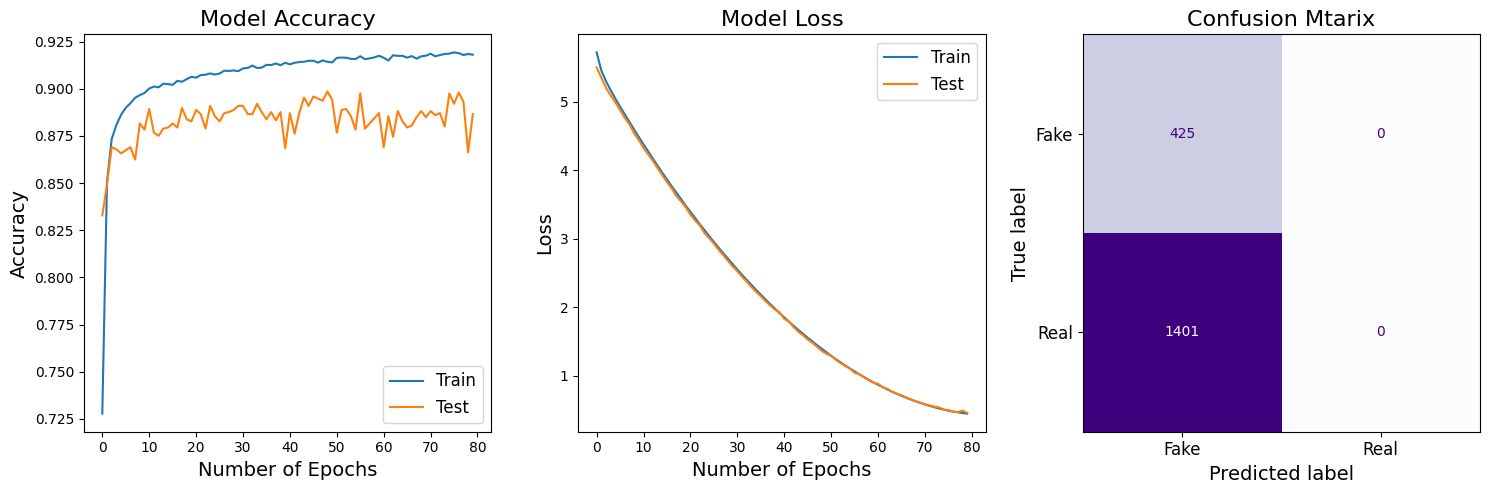

In [6]:
Plot_history(X_test, y_pred, history)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.23      1.00      0.38       425
           1       0.00      0.00      0.00      1401

    accuracy                           0.23      1826
   macro avg       0.12      0.50      0.19      1826
weighted avg       0.05      0.23      0.09      1826



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9194 - loss: 0.4202


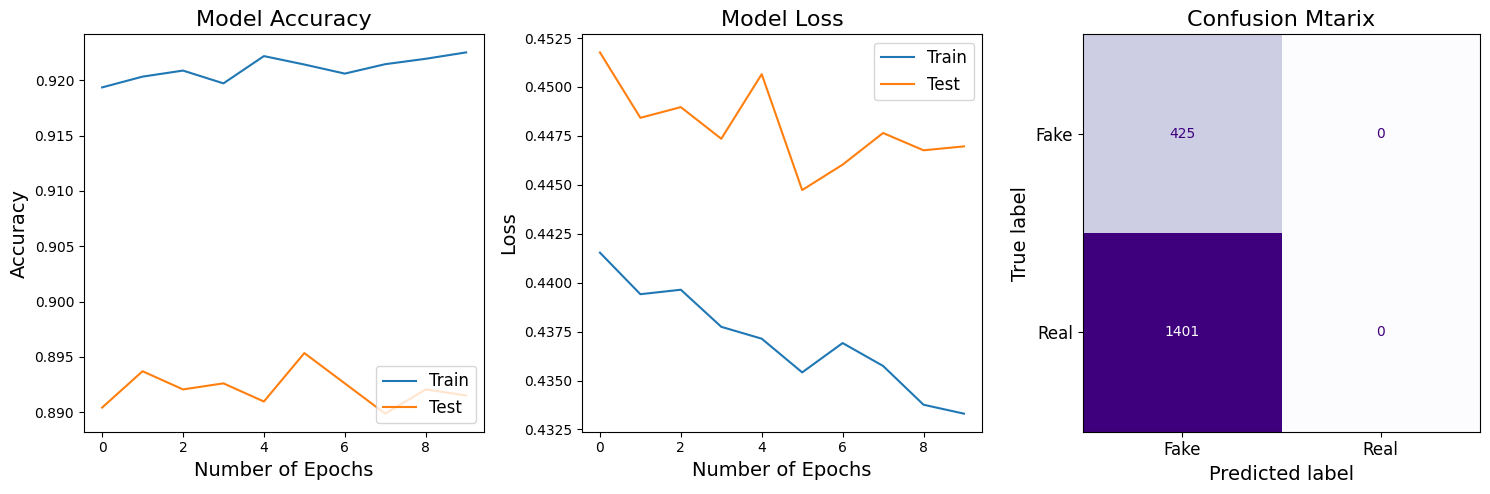

In [10]:
Plot_history(X_test, y_pred, history01)

40/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1719037571.126568    1174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       425
           1       1.00      0.89      0.94      1401

    accuracy                           0.91      1826
   macro avg       0.86      0.94      0.89      1826
weighted avg       0.93      0.91      0.92      1826

1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9119 - loss: 0.1834


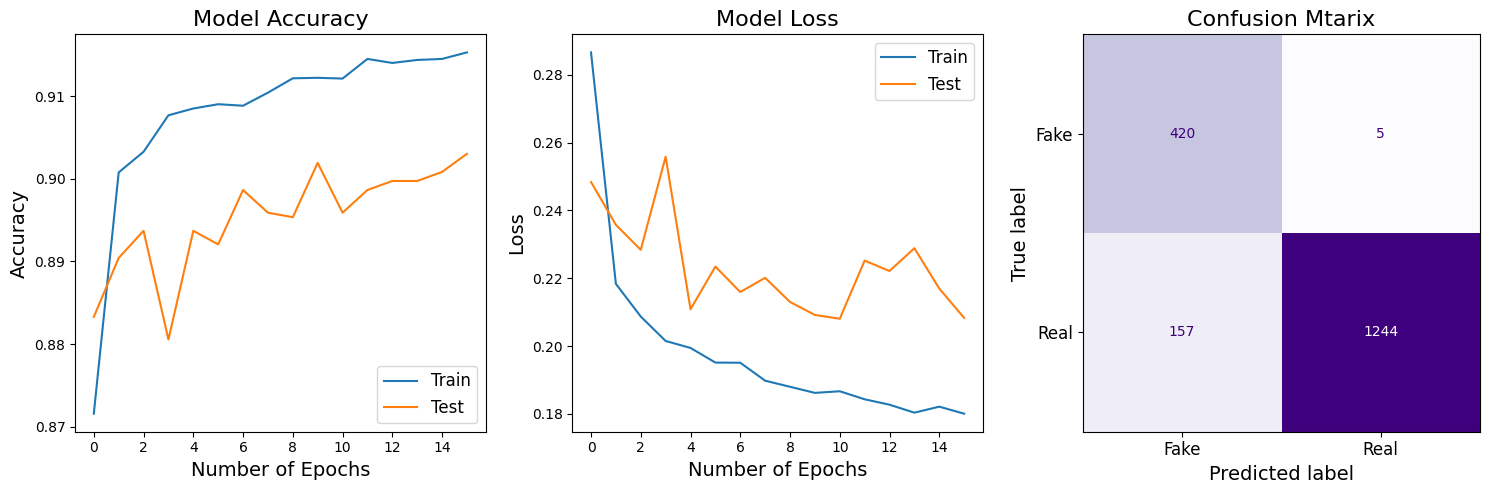

In [6]:
Plot_history(X_test, y_pred, history)

In [11]:
model.save("MHT-fused.h5")

In [18]:
X_train, X_test, y_train, y_test = train_test_split(XO, yO, test_size = .2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

38/38 - 0s - 4ms/step - accuracy: 0.9564 - loss: 0.1386

Test accuracy: 0.9563785791397095


In [38]:
# Define the ResNet model
def resnet_model(input_shape, num_blocks, filters, kernel_size, dropout, name="resnet"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # Initial Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Residual Blocks
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dropout)

    # Flatten the output
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(filters * 2, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(filters, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define the Residual Block
def residual_block(x, filters, kernel_size, dropout):
    shortcut = x

    # First Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    # Second Conv layer
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)

    # Adding the shortcut to the main path
    x = layers.add([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

# Define parameters
input_shape = X_train.shape[1:]  # Adjust the input shape as per your data
num_blocks = 3
filters = 64
kernel_size = 3
dropout = 0.3

# Build the model
model = resnet_model(
    input_shape=input_shape,
    num_blocks=num_blocks,
    filters=filters,
    kernel_size=kernel_size,
    dropout=dropout,
)
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=80,callbacks=[early_stopping],)
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "resnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 500)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 40, 64)    │     96,064 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 20, 64)    │     12,352 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 20, 64)    │     12,352 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 20, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 20, 64)    │          0 │ add_15[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 20, 64)    │     12,352 │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 20, 64)    │     12,352 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 20, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 20, 64)    │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 20, 64)    │     12,352 │ activation_16[0]

 Total params: 188,674 (737.01 KB)

 Trainable params: 187,778 (733.51 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.8275 - loss: 0.3652 - val_accuracy: 0.8986 - val_loss: 0.2128
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9096 - loss: 0.1995 - val_accuracy: 0.9025 - val_loss: 0.2007
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9184 - loss: 0.1834 - val_accuracy: 0.9025 - val_loss: 0.1981
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9269 - loss: 0.1667 - val_accuracy: 0.9134 - val_loss: 0.1881
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9297 - loss: 0.1575 - val_accuracy: 0.9195 - val_loss: 0.1824
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9347 - loss: 0.1489 - val_accuracy: 0.9184 - val_loss: 0.1787
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9394 - loss: 0.1443 - val_accuracy: 0.9222 - val_loss: 0.1838
Epoch 8/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9470 - loss: 0.1308 

In [41]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(XO, yO, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

38/38 - 0s - 3ms/step - accuracy: 0.9235 - loss: 0.1796

Test accuracy: 0.9234567880630493
171/171 - 1s - 5ms/step - accuracy: 0.9164 - loss: 0.1958

Test accuracy: 0.9163922667503357


In [49]:
del model

In [26]:
model.save("/kaggle/working/resnet-fused.h5")

In [13]:
# Define the Wave-U-Net model
def wave_unet_model(input_shape, num_layers, filters, kernel_size, dropout, name="wave_unet"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # Encoder (Downsampling path)
    skips = []
    x = inputs
    for _ in range(num_layers):
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        skips.append(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        filters *= 2

    # Bottleneck
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    # Decoder (Upsampling path)
    for skip in reversed(skips):
        filters //= 2
        x = layers.Conv1DTranspose(filters, kernel_size, strides=2, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        # Ensure skip connection dimensions match
#         print(skip.shape[1])
#         print(x.shape[1])
        if skip.shape[1] != x.shape[1]:
            skip = layers.MaxPooling1D(pool_size=2)(skip)
#         print(skip.shape[1])
#         print(x.shape[1])
        x = layers.Concatenate(axis=1)([x, skip])
        x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

    # Output layer
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(filters, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(filters // 2, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2, activation="softmax", name="outputs")(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define parameters
input_shape =  X_train.shape[1:] 
num_layers = 4
filters = 64
kernel_size = 3
dropout = 0.3

# Build the model
model = wave_unet_model(
    input_shape=input_shape,
    num_layers=num_layers,
    filters=filters,
    kernel_size=kernel_size,
    dropout=dropout,
)

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=80,callbacks=[early_stopping])
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "wave_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 500)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 40, 64)    │     96,064 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 20, 128)   │     24,704 │ max_pooling1d_24… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 10, 256)   │     98,560 │ max_pooling1d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 5, 256)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 5, 512)    │    393,728 │ max_pooling1d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 512)    │      2,048 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 2, 512)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 2, 1024)   │  1,573,888 │ max_pooling1d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 1024)   │      4,096 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_12 │ (None, 4, 512)    │  1,573,376 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 512)    │      2,048 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 2, 512)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 6, 512)    │          0 │ batch_normalizat

 Total params: 5,356,834 (20.43 MB)

 Trainable params: 5,348,898 (20.40 MB)

 Non-trainable params: 7,936 (31.00 KB)

Epoch 1/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.8010 - loss: 0.4890 - val_accuracy: 0.8731 - val_loss: 0.2678
Epoch 2/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9481 - loss: 0.1568 - val_accuracy: 0.9572 - val_loss: 0.1156
Epoch 3/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9730 - loss: 0.0862 - val_accuracy: 0.9638 - val_loss: 0.0885
Epoch 4/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9844 - loss: 0.0527 - val_accuracy: 0.9753 - val_loss: 0.0546
Epoch 5/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9802 - val_loss: 0.0533
Epoch 6/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9892 - loss: 0.0383 - val_accuracy: 0.9720 - val_loss: 0.0968
Epoch 7/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9957 - loss: 0.0173 - val_accuracy: 0.9819 - val_loss: 0.0461
Epoch 8/80
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9938 - loss: 0.0173 - val_acc

In [15]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

171/171 - 1s - 4ms/step - accuracy: 0.9962 - loss: 0.0111

Test accuracy: 0.9961580634117126
115/115 - 2s - 20ms/step - accuracy: 0.6667 - loss: 1.7381

Test accuracy: 0.6666666865348816
514/514 - 4s - 7ms/step - accuracy: 0.6737 - loss: 1.6848

Test accuracy: 0.6736880540847778


In [ ]:
model.save("/kaggle/working/GRU-fused.h5")

In [19]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/MHT-fused.h5')

In [16]:
# Define the Wave2Vec model
def wave2vec_model(input_shape, num_layers, units, dropout, name="wave2vec"):
    inputs = keras.Input(shape=input_shape, name="inputs")

    # Convolutional feature extractor (similar to Wave2Vec)
    x = layers.Conv1D(512, 10, strides=5, padding='same', activation='relu', name='conv1')(inputs)
    x = layers.Conv1D(512, 8, strides=4, padding='same', activation='relu', name='conv2')(x)
    x = layers.Conv1D(512, 4, strides=2, padding='same', activation='relu', name='conv3')(x)
    x = layers.Conv1D(512, 4, strides=2, padding='same', activation='relu', name='conv4')(x)
    x = layers.Conv1D(512, 4, strides=2, padding='same', activation='relu', name='conv5')(x)
    x = layers.Conv1D(512, 4, strides=2, padding='same', activation='relu', name='conv6')(x)

    # Flatten the output from convolutional layers
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units // 2, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax', name='outputs')(x)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

# Define parameters
input_shape = X_train.shape[1:] 
num_layers = 6
units = 256
dropout = 0.3

# Build the model
model = wave2vec_model(
    input_shape=input_shape,
    num_layers=num_layers,
    units=units,
    dropout=dropout,
)
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=80,callbacks=[early_stopping])
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "wave2vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 40, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 8, 512)         │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 2, 512)         │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1, 512)         │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 1, 512)         │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 1, 512)         │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv1D)                  │ (None, 1, 512)         │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,019,010 (34.40 MB)

 Trainable params: 9,019,010 (34.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8764 - loss: 0.2677 - val_accuracy: 0.8997 - val_loss: 0.2051
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9180 - loss: 0.1732 - val_accuracy: 0.9014 - val_loss: 0.1982
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9383 - loss: 0.1362 - val_accuracy: 0.9063 - val_loss: 0.2278
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9635 - loss: 0.0865 - val_accuracy: 0.9112 - val_loss: 0.2681
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9848 - loss: 0.0408 - val_accuracy: 0.9129 - val_loss: 0.3670
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9905 - loss: 0.0241 - val_accuracy: 0.9112 - val_loss: 0.4936
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9936 - loss: 0.0182 - val_accuracy: 0.9107 - val_loss: 0.7276
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
58/58

In [19]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

514/514 - 2s - 4ms/step - accuracy: 0.9250 - loss: 0.1515

Test accuracy: 0.9249969720840454
115/115 - 0s - 4ms/step - accuracy: 0.9178 - loss: 0.1669

Test accuracy: 0.9178307056427002
514/514 - 2s - 4ms/step - accuracy: 0.9250 - loss: 0.1515

Test accuracy: 0.9249969720840454


In [20]:
def conv_block(inputs, num_filters):
    x = layers.Conv1D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling1D(2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv1DTranspose(num_filters, 3, strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(d4)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

# Define parameters
input_shape = (40, 500)  # Adjusted input shape for features like MFCCs
num_classes = 2

# Build the model
model = build_unet(
    input_shape=input_shape,
    num_classes=num_classes
)
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=80,callbacks=[early_stopping])
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "wavenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 40, 500)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 40, 64)    │     64,064 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 40, 64)    │      8,256 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 40, 64)    │      8,256 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 40, 64)    │          0 │ conv1d_41[0][0],  │
│                     │                   │            │ conv1d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 40, 64)    │      4,160 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 64)    │          0 │ conv1d_43[0][0],  │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 40, 64)    │          0 │ conv1d_44[0][0],  │
│ (Multiply)          │                   │            │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 40, 64)    │      4,160 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 40, 64)    │          0 │ conv1d_46[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 40, 64)    │          0 │ conv1d_47[0][0],  │
│ (Multiply)          │                   │            │ conv1d_48[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 40, 64)    │      4,160 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 40, 64)    │          0 │ conv1d_49[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 40, 64)    │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 40, 64)    │          0 │ conv1d_50[0][0],  │
│ (Multiply)          │                   │            │ conv1d_51[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 40, 64)    │      4,160 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 705,090 (2.69 MB)

 Trainable params: 705,090 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 133s 80ms/step - accuracy: 0.7894 - loss: 0.4503 - val_accuracy: 0.8926 - val_loss: 0.2346
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.9159 - loss: 0.1913 - val_accuracy: 0.9090 - val_loss: 0.2012
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.9377 - loss: 0.1525 - val_accuracy: 0.9129 - val_loss: 0.2074
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.9518 - loss: 0.1245 - val_accuracy: 0.9085 - val_loss: 0.2206
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.9645 - loss: 0.0958 - val_accuracy: 0.9047 - val_loss: 0.2284
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.9749 - loss: 0.0724 - val_accuracy: 0.9052 - val_loss: 0.2740
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.9858 - loss: 0.0449 - val_accuracy: 0.9030 - val_loss: 0.3019
Epoch 7: early stopping
Restoring model weights from the end of the best ep

In [21]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

58/58 - 0s - 8ms/step - accuracy: 0.9299 - loss: 0.1635

Test accuracy: 0.9299014210700989
115/115 - 5s - 40ms/step - accuracy: 0.9329 - loss: 0.1595

Test accuracy: 0.9328951239585876
514/514 - 7s - 14ms/step - accuracy: 0.9402 - loss: 0.1460

Test accuracy: 0.9401558637619019


In [23]:
del model

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def conv_block(inputs, num_filters):
    x = layers.Conv1D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling1D(2)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = layers.Conv1DTranspose(num_filters, 3, strides=2, padding="same")(inputs)
    x = layers.Concatenate(axis=1)([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(d4)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

# Define parameters
input_shape = (40, 500)  # Adjusted input shape for features like MFCCs, transpose to match Conv1D requirements
num_classes = 2

# Build the model
model = build_unet(
    input_shape=input_shape,
    num_classes=num_classes
)

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=32, epochs=80,callbacks=[early_stopping])
    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40, 500)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 64)    │     96,064 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 40, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 40, 64)    │     12,352 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 40, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 64)    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 20, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 128)   │     49,280 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 20, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 128)   │          0 │ re_lu_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 256)   │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 10, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 10, 256)   │    196,864 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,612,546 (40.48 MB)

 Trainable params: 10,600,770 (40.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/80
   7/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5212 - loss: 0.7138 

I0000 00:00:1719052520.731264     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - accuracy: 0.8407 - loss: 0.3234 - val_accuracy: 0.8953 - val_loss: 0.2035
Epoch 2/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9119 - loss: 0.1851 - val_accuracy: 0.9096 - val_loss: 0.1955
Epoch 3/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9295 - loss: 0.1597 - val_accuracy: 0.9145 - val_loss: 0.1843
Epoch 4/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9404 - loss: 0.1455 - val_accuracy: 0.9195 - val_loss: 0.1874
Epoch 5/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9413 - loss: 0.1389 - val_accuracy: 0.9249 - val_loss: 0.1795
Epoch 6/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9477 - loss: 0.1258 - val_accuracy: 0.9184 - val_loss: 0.1868
Epoch 7/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9494 - loss: 0.1211 - val_accuracy: 0.9238 - val_loss: 0.1842
Epoch 8/80
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9587 - loss: 0.10

In [5]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = .5, random_state=42)
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

58/58 - 0s - 7ms/step - accuracy: 0.9348 - loss: 0.1466

Test accuracy: 0.9348302483558655
115/115 - 3s - 23ms/step - accuracy: 0.9433 - loss: 0.1406

Test accuracy: 0.9433032274246216
514/514 - 6s - 11ms/step - accuracy: 0.9523 - loss: 0.1298

Test accuracy: 0.9522708058357239


In [6]:
model.save("/kaggle/working/U-Net.h5")

In [16]:
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
print("librosa version:", librosa.__version__)

Keras version: 3.3.3
TensorFlow version: 2.15.0
librosa version: 0.10.2.post1
